In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string, os
import nltk
import re
import keras
import random
import io
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adamax
import sys
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image, ImageDraw, ImageFont
import pickle
import warnings
warnings.filterwarnings("ignore")

# 并不成功的歌词预测

## RNN

In [2]:
dataset = pd.read_csv("D:/intro/DaSE_intro/final/lyrics/lyrics_2006-2022.csv", encoding = 'utf-8')

def album_year(row):
    if row['album_name'] == 'Taylor Swift':
        return '2006'
    elif row['album_name'] == 'Fearless (Taylor’s Version)':
        return '2008'
    elif row['album_name'] == 'Speak Now (Deluxe)':
        return '2010'
    elif row['album_name'] == 'Red (Deluxe Edition)':
        return '2012'
    elif row['album_name'] == '1989 (Deluxe)':
        return '2014'
    elif row['album_name'] == 'reputation':
        return '2017'
    elif row['album_name'] == 'Lover':
        return '2019'
    elif row['album_name'] == 'evermore (deluxe version)':
        return '2020'
    elif row['album_name'] == 'folklore (deluxe version)':
        return '2021' #与上一张专辑年份稍微区分一下，方便画图好看
    elif row['album_name'] == 'midnights (3am edition)'or row['album_name'] == 'midnights':
        return '2022'
    return 'No Date' #其他错误情况
dataset

,album_name,track_title,track_n,lyric,line
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5
...,...,...,...,...,...
9365,Speak Now (Deluxe),Superman,17,I'll be right here on the ground,51
9366,Speak Now (Deluxe),Superman,17,When you come back down,52
9367,Speak Now (Deluxe),Superman,17,"La, la, la, la, la, la",53
9368,Speak Now (Deluxe),Superman,17,"La, la, la, la, la, la",54


In [3]:
corpus = ''
for item in dataset['lyric']:
    corpus += item

corpus = corpus.lower()
print("number of unique characters:", len(set(corpus)))
print("unique characters:", sorted(set(corpus)))

number of unique characters: 67
unique characters: [' ', '!', '"', '&', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '\xa0', 'é', 'í', 'ï', 'ó', 'е', '\u2005', '\u200b', '–', '—', '‘', '’', '”', '…', '\u205f']


In [4]:
remove = ['!', '"', '&', "'", '(', ')', '-','?', '[', ']','|', '\xa0', 'é', 'í', 'ï', 'ó', 'е', 
          '\u2005', '\u200b', '–', '—', '‘', '’', '”', '…', '\u205f']

for symbol in remove:
    corpus = corpus.replace(symbol, " ")

print("unique characters:", sorted(set(corpus)))

unique characters: [' ', ',', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
symbol = sorted(list(set(corpus)))
corpus_len = len(corpus)
symbol_len = len(symbol)

# enumerate：遍历，返回编号和元素，编号从0开始
# 字符和数字之间的一一对应
mapping = dict((c, i) for i, c in enumerate(symbol))
reverse_mapping = dict((i, c) for i, c in enumerate(symbol))

print("total number of characters:", corpus_len)
print("number of unique characters:", symbol_len)

total number of characters: 321460
number of unique characters: 41


In [6]:
# 把corpus分成等长字符串
length = 40
features = []
targets = []

# 将字符转化为数字再输入
for i in range(0, corpus_len - length):
    feature = corpus[i : i + length]
    target = corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
datapoints = len(targets)
print("total number of sequences in the corpus:", datapoints)

total number of sequences in the corpus: 321420


In [7]:
# reshape X and normalize
X = (np.reshape(features, (datapoints, length, 1)))/ float(symbol_len)

# one hot encode the output variable
y = np_utils.to_categorical(targets)

In [8]:
# 建立模型

# 模型初始化
model = Sequential()

# 添加layers
model.add(LSTM(256, input_shape = (X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation = 'softmax'))

# 将用于训练的模型编译出来 
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)
           
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense (Dense)               (None, 41)                10537     
                                                                 
Total params: 274,729
Trainable params: 274,729
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 训练模型
history = model.fit(X, y, batch_size = 128, epochs = 100)

Epoch 1/100
2512/2512 [==============================] - 242s 95ms/step - loss: 2.6948
Epoch 2/100
2512/2512 [==============================] - 238s 95ms/step - loss: 2.4975
Epoch 3/100
2512/2512 [==============================] - 245s 97ms/step - loss: 2.3464
Epoch 4/100
2512/2512 [==============================] - 237s 94ms/step - loss: 2.2143
Epoch 5/100
2512/2512 [==============================] - 238s 95ms/step - loss: 2.1080
Epoch 6/100
2512/2512 [==============================] - 243s 97ms/step - loss: 2.0205
Epoch 7/100
2512/2512 [==============================] - 249s 99ms/step - loss: 1.9492
Epoch 8/100
2512/2512 [==============================] - 238s 95ms/step - loss: 1.8916
Epoch 9/100
2512/2512 [==============================] - 238s 95ms/step - loss: 1.8431
Epoch 10/100
2512/2512 [==============================] - 239s 95ms/step - loss: 1.7969
Epoch 11/100
2512/2512 [==============================] - 240s 95ms/step - loss: 1.7575
Epoch 12/100
2512/2512 [=================

In [21]:
# 将model保存下来
with open("saved_model_rfc.pickle",'wb') as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://0aa38510-20e3-4f6e-90c7-5aaa126f5acb/assets


INFO:tensorflow:Assets written to: ram://0aa38510-20e3-4f6e-90c7-5aaa126f5acb/assets


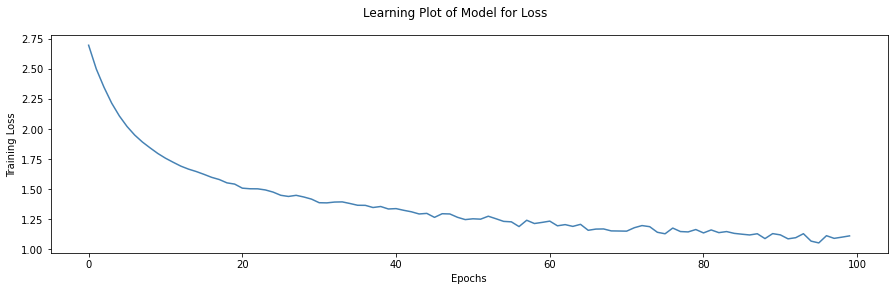

In [10]:
# 评价该模型
history_df = pd.DataFrame(history.history)

fig = plt.figure(figsize = (15,4))
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color = "steelblue")
pl.set(ylabel = "Training Loss")
pl.set(xlabel = "Epochs")
plt.savefig('D:/intro/DaSE_intro/final/pics/model_loss.png',dpi=1000)

In [13]:
# 加载模型并预测
import pickle

with open("D:/intro/DaSE_intro/final/saved_model_rfc.pickle",'rb') as f:
    model0 = pickle.load(f)

In [13]:
# 预测函数
def Lyrics_Generator(starter,Ch_count): # temperature=1.0:
    generated= ""
    starter = starter 
    seed=[mapping[char] for char in starter]
    generated += starter 
    # Generating new text of given length
    for i in range(Ch_count):
        seed=[mapping[char] for char in starter]
        x_pred = np.reshape(seed, (1, len(seed), 1))
        x_pred = x_pred/ float(symbol_len)
        prediction = model.predict(x_pred, verbose=0)[0]  
        # Getting the index of the next most probable index
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / 1.0 
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, prediction, 1)
        index = np.argmax(prediction)
        next_char = reverse_mapping[index]  
        # Generating new text
        generated += next_char
        starter = starter[1:] + next_char
    return generated

In [19]:
song_1 = Lyrics_Generator("i want to know if you can sit with pain.", 400)
print(song_1)

i want to know if you can sit with pain.me thi nooe of the nog oh mes bele pinei was the tort blante  but i don t wanna moss youyou re not sorryno, oo, oh,ohyou left me that lt whll you wait an tid rame  well and whan you re soinl  i go bnand acrytakeand i love you bgaina dorna dooeaut  caby, babk updid you move mive with the gerltateaid rtmeet i m nns as axy  huy dodn the same niseand i nov to looking an mrst snceshes le to  go d getaw


In [22]:
song_2 = Lyrics_Generator("for fear of losing you,i would never cry", 400)
print(song_2)

for fear of losing you,i would never crye gealing you li never gete you lo co a smaks to goower and wou re the one i want  andi  bod  ol,  sooe attt ai  ah, ah, ah, ah, ah, ah, aaby, thit in the cack of your manding at all when ye were say, it s ll tseeryou know i love a london boy, i en rherker dian t stu wothd you know tomething sha wirdowshe said  see s she thaseion semoe  the woast you make this way tooething you dod the rool  oo sh
